This following code is adapted from https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34 by Donghao Zhang and Qingfeng Tong. We use the pretrained VGG19 model to cluster the images sampled from ShapeNet (currently 270 .png images of aeroplanes). This is to create a meaning space with visually similar graphs, which is fashioned after Hawkins et al. (2023).

In [1]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input

# models
from keras.applications.vgg19 import VGG19
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

path = r"/Users/will/Desktop/stimuli/aeroplanes"
# change the working directory to the path where the images are located
os.chdir(path)

In [2]:
# this list holds all the image filename
flowers = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            flowers.append(file.name)

In [3]:
model = VGG19()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)


In [4]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx)
    print(features)
    return features

In [5]:
data = {}
p = r"/Users/will/Desktop/stimuli/ShapeNetRendering/02691156/1a04e3eab45ca15dd86060f189eb133/plane_features.pkl"

# lop through each image in the dataset
for flower in flowers:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(flower,model)
        data[flower] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
[[0.        1.7717671 1.1945668 ... 2.2611756 0.        0.       ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
[[0.        0.        2.645495  ... 4.2475653 0.        0.       ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
[[0.        0.5685589 2.756476  ... 4.7753296 0.        0.       ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
[[0.        0.        0.        ... 2.9319024 0.        0.       ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[[0.         0.41686776 0.33802062 ... 3.2726803  0.         0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
[[0.         0.         0.19665736 ... 3.9067981  0.         0.9861895 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
[[0.         0.49841923 0.         ... 2.716742   0.8647153  0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
[[0.        0.        1.6756039 ... 7.141223  0.        0.       ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
[[0.        0.3898866 0.        ... 2.9829435 0.6328926 0.       ]]
1/1 ━━━━━━━━━━━━━━━

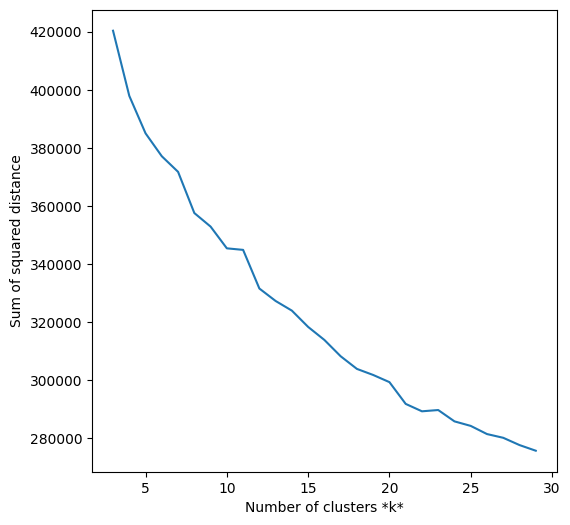

In [6]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)

# get the unique labels (from the flower_labels.csv)
df = pd.read_csv('plane.csv')
label = df['label'].tolist()
unique_labels = list(set(label))

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

# cluster feature vectors
kmeans = KMeans(n_clusters=len(unique_labels), random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# function that lets you view a cluster (based on identifier)
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')


# this is just incase you want to see which value for k might be the best
sse = []
list_k = list(range(3, 30))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)

    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [7]:
#to see the file names of any clusters
groups[19]

['00 240.png',
 '00 256.png',
 '00 126.png',
 '00 141.png',
 '00 223.png',
 '00 237.png',
 '00 191.png',
 '00 233.png',
 '00 203.png',
 '00 149.png',
 '00 148.png',
 '00 160.png',
 '00 163.png',
 '00 86.png',
 '00 54.png',
 '00 83.png',
 '00 210.png',
 '00 57.png',
 '00 33.png']